# UVA-ARC-Alaska: Intro to data exploration

This research notebook provides an introductory example of data exploration using the UVA-ARC data service. 

## 1. Installing dependencies

In [40]:
#
# What we are doing here is to install all the dependencies for this particular research notebook.
# We will prceed then to install and configure the environment we need to use.
# What you will see below this box is the output of the commands we have here:
#
#!module load anaconda
#!conda create -n uva-arc --y
#!source activate uva-arc
#!python -m ipykernel install --user --name=UVA-ARC
#
!pip install h5pyd==0.15.1 seaborn==0.12.2 matplotlib==3.7.2 numpy==1.24.4 pandas==2.0.3

Defaulting to user installation because normal site-packages is not writeable


## 2. Loading dependencies

Once all the dependencies are installed, we can proceed to load them so they can be used on this notebook. These dependencies include the extension for us to use the Highly Scalable Data Service, for example, but also for us to plot better graphs.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import datetime
import h5pyd
import time

In [3]:
#
# Settings for plotting graphs
# 
%matplotlib inline
#
# Determine graph size
sns.set(rc={'figure.figsize':(18, 8)})
#
# Disable future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 3. Load HDF data store

In [4]:
#
# Load the datastore from HSDS:
# You have two options:
# 1. To load the static data store with all the data from the 08-2022 until 05-2023
# 2. To load the dynamic data store with the most updated data 08-2022 until the present time
#
# Dynamic dataset
filepath = "hdf5://projects/nsfarctic/uva-arc-alaska.h5"

# Static dataset
#filepath = "hdf5:///projects/nsfarctic/uva-arc-alaska-2022-2023.h5"

In [5]:
#
# Open HSDS datastore as 'f'
#
# Please note:
# Set use_cache to False to pick up any real-time changes
# This is useful if the analyst wants to include the latest data batch
#
f = h5pyd.File(filepath, mode='r', use_cache=True)

In [6]:
#
# Useful functions:
#
# Convert np bytestring values to string
# to make things easier when working with dataframes
# 
def convert_bytestr_to_str(df):
    df_converted = df
    for col, dtype in df.dtypes.items():
        if dtype == object:
            df[col] = df[col].str.decode('utf-8')
    return df_converted

#
# Convert timestamp (ts) in seconds to a date-time string
# Note: in the database, all datetime is stored in seconds 
#
def ts_to_str(ts):
    value = datetime.datetime.utcfromtimestamp(ts)
    s = value.isoformat(sep=' ', timespec='seconds')
    return s

#
# Show HDF5 attributes
# 
def dump_attrs(obj):
    for k in obj.attrs:
        v = obj.attrs[k]
        print(f"{k}: {v}")

## 4. Show data store root attributes

In [7]:
dump_attrs(f)

schema: hobo-general
schema_version: 0.1
Conventions: CF-1.8
title: NSF Project: Understanding the Changing Natural-Built Landscape in an Arctic Community: An integrated sensor network in Utqiagvik, Alaska
institution: U. of Virginia / U. of Notre Dame / National Science Foundation, Navigating the New Arctic program.
source: surface atmospheric observations.
references: https://www.nsf.gov/awardsearch/showAward?AWD_ID=2022639
history: 
license: CC-BY 4.0 International
authors: LF Murillo, John Readey, Kate Kirwan, Mirella Shaban, Howard Epstein
authors_contact: lrosadom@nd.edu
comment: 
last_updated_metadata: 1703525831
last_updated_data: 1703525846


## 5. Display minutes elapsed since the last data update

In [8]:
# Display minutes since last_updated_data!
(int(time.time()) - f.attrs['last_updated_data']) // 60

533

In [9]:
# Get last_update_data date and time
timestamp = f.attrs["last_updated_data"]
print(ts_to_str(timestamp))

2023-12-25 17:37:26


In [10]:
# Display current date and time
ts_to_str(time.time())

'2023-12-26 02:30:52'

## 6. Reading the loggers table

In [11]:
#
# Read loggers / stations
# Here we are going to read the table "loggers" with all the metadata for individual stations
#
# This first line selects the table we want ("loggers")
loggers = f["loggers"]
arr_loggers = loggers.value
df_loggers = pd.DataFrame(arr_loggers)
df_loggers

sn  schema_version  active                  name     name_ipk  \
0  b'21198259'             1.0       1   b'RX3000_BRW1_TNHA'      b'TNHA'   
1  b'21401801'             1.0       1   b'RX3000_BRW4_SSMH'  b'SSMH-B01'   
2  b'21401800'             1.0       1  b'RX3000_BRW5_BUECI'     b'BUECI'   
3  b'21401803'             1.0       1    b'RX3000_BRW6_BEO'       b'BEO'   

                model location_en location_ipk        lat         lat_units  \
0  b'HOBOLink RX3000'     b'TNHA'      b'TNHA'  71.290567  b'degrees_north'   
1  b'HOBOLink RX3000'     b'SSMH'      b'SSMH'  71.297333  b'degrees_north'   
2  b'HOBOLink RX3000'    b'BUECI'     b'BUECI'  71.292483  b'degrees_north'   
3  b'HOBOLink RX3000'      b'BEO'       b'BEO'  71.275600  b'degrees_north'   

          lon        lon_units  height height_units  altitude altitude_units  \
0 -156.768517  b'degrees_east'     0.0         b'm'     6.096           b'm'   
1 -156.727650  b'degrees_east'     1.0         b'm'     0.000           b'm'   
2 -156.777300  b'degrees_east'     1.0         b'm'     1.000           b'm'   
3 -156.641617  b'degrees_east'     1.0         b'm'     4.572           b'm'   

   battery_level_max  battery_level_min battery_units  last_query  
0                4.2                3.0          b'V'  1703525846  
1                4.2                3.0          b'V'  1703525847  
2                4.2                3.0          b'V'  1703525849  
3                4.2                3.0          b'V'  1703525849

In [12]:
#
# Next, we display logger name, number, and last time they were updated
#
logger_list = {}

for i in range(loggers.nrows):
    row = loggers[i]
    logger_sn = row['sn'].decode('utf-8')
    logger_site = row['location_en'].decode('utf-8')    
    logger_list[logger_site] = logger_sn
    lat = format(row['lat'], '.6f')
    lon = format(row['lon'], '.6f')
    last_query_ts = row['last_query']
    last_query_datestr = ts_to_str(last_query_ts)
    print(f"logger: {logger_sn}, site: {logger_site}, latitude: {lat}, longitude: {lon}, last query run: {last_query_datestr}")

#
# Now we can use the list we just created to query loggers:
# Just call: logger_list['BUECI'], logger_list['TNHA'], etc.
#

logger: 21198259, site: TNHA, latitude: 71.290567, longitude: -156.768517, last query run: 2023-12-25 17:37:26
logger: 21401801, site: SSMH, latitude: 71.297333, longitude: -156.727650, last query run: 2023-12-25 17:37:27
logger: 21401800, site: BUECI, latitude: 71.292483, longitude: -156.777300, last query run: 2023-12-25 17:37:29
logger: 21401803, site: BEO, latitude: 71.275600, longitude: -156.641617, last query run: 2023-12-25 17:37:29


## 5. Reading the sensors table

In [13]:
#
# First, read the sensors database from the HDF store
#
sensors = f['sensors']

# Then, convert the database into an array...
# so it can be converted finally to a dataframe:
arr = sensors.value
df = pd.DataFrame(arr)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#
# Now we can display the DF in its full glory
#
df_sensors = convert_bytestr_to_str(df)
df_sensors[6:].head()
#
# Pretty fancy, if you ask me 8-)
# Now you know what sensor you are looking at, where it is, its characteristics, etc.
# You can use that metadata for quality control, but also for data viz!
# 

sn sn_logger  schema_version  active           long_name  \
6    21398719-3  21401800             1.0       1      Wind Direction   
7   21398593-13  21198259             1.0       1  Ground Temperature   
8   21398584-12  21401800             1.0       1  Ground Temperature   
9   21398599-16  21401801             1.0       1  Ground Temperature   
10   21362317-1  21198259             1.0       1     Solar Radiation   

          standard_name                                   sensor_type  \
6   wind_from_direction                                wind direction   
7      soil_temperature  Multi-Depth Soil Moisture/Temperature Sensor   
8      soil_temperature  Multi-Depth Soil Moisture/Temperature Sensor   
9      soil_temperature  Multi-Depth Soil Moisture/Temperature Sensor   
10     solar_irradiance                           Silicon Pyranometer   

               model        lat      lat_units         lon     lon_units  \
6   HOBO RXW-WCF-900  71.292183  degrees_north -156.778717  degrees_east   
7   HOBO RXW-GP6-910  71.290567  degrees_north -156.768517  degrees_east   
8   HOBO RXW-GP6-900  71.291867  degrees_north -156.777933  degrees_east   
9   HOBO RXW-GP6-900  71.297733  degrees_north -156.728050  degrees_east   
10  HOBO RXW-LIB-900  71.290567  degrees_north -156.768517  degrees_east   

    height height_units  angle angle_units  altitude altitude_units  \
6   2.7940            m    0.0     degrees       0.0              m   
7  -0.5500            m    0.0     degrees       0.0              m   
8  -0.5000            m    0.0     degrees       0.0              m   
9  -0.8500            m    0.0     degrees       0.0              m   
10  3.2258            m    0.0     degrees       0.0              m   

   mount_structure mount_aspect  mount_corner  convergence  battery_level_max  \
6                                           0            0                4.2   
7                                           0            0                4.2   
8                                           0            0                4.2   
9                                           0            0                4.2   
10                                          0            0                4.2   

    battery_level_min battery_units     accuracy   resolution  \
6                 3.0             v  +-7 degrees  1.4 degrees   
7                 3.0             v       ±0.5 C        0.1 C   
8                 3.0             v       ±0.5 C        0.1 C   
9                 3.0             v       ±0.5 C        0.1 C   
10                3.0             v   +-10 W m-2   1.25 W m-2   

              drift                                          datasheet  \
6                    https://www.onsetcomp.com/sites/default/files/...   
7                                                                        
8                                                                        
9                                                                        
10  < +-2% per year  https://www.onsetcomp.com/sites/default/files/...   

   measurement_type  measurement_min  measurement_max measurement_units  \
6    Wind Direction              0.0            355.0           degrees   
7       Temperature            -20.0             70.0                 C   
8       Temperature            -20.0             70.0                 C   
9       Temperature            -20.0             70.0                 C   
10  Solar Radiation              0.0           1280.0             W/m-2   

    missing_values  
6           -999.9  
7           -999.9  
8           -999.9  
9           -999.9  
10          -999.9

## 6. Reading the data table

In [16]:
#
# Reading sensor data from our "data" table in the HDF5 datastore:
# Now that we have all the relevant info about our stations and sensors,
# let's read the dataset and pass to a variable called 'data_table'
# 
data_table = f['data']

#
# Let's see the dimensions of this dataset in the output below this box:
# 
data_table

<HDF5 dataset "data": shape (8280577,), type "|V48">

In [17]:
# Display the total number of observations (lines)
data_table.nrows

8280577

In [18]:
# Display the last line of the dataset
data_table[-1]

(b'21401803', b'21401803-B', 1, 12, 4.29931694, 1703514900)

In [19]:
%%time
# 
# We can convert from numpy array to Pandas dataframe as well!
# Pandas is slower but greater for manipulating, converting, plotting, etc.
# (in short, it is great for data exploration and viz)
#
# Note:
# Using "%time" before any instruction tells us the time spent per instruction
#
arr = data_table.value
df = pd.DataFrame(arr)

CPU times: user 1.63 s, sys: 1.1 s, total: 2.72 s
Wall time: 3.56 s


In [20]:
%%time
#
# Now we perform an extra step in the conversion of HSDS into Pandas:
# We take the values that were in binary string representation and make them into regular strings...
# This is just to make things easier when working with dataframes
#
df = convert_bytestr_to_str(df)
#df

CPU times: user 3.32 s, sys: 433 ms, total: 3.76 s
Wall time: 3.77 s


## Working with data from one site at a time

In [21]:
#
# Say you want to work with data from a particular site
# You can just declare the site you want from "logger_list"
# 
# In this example, we select only the data from the TNHA site
# 
df_tnha = df[df['logger_sn']=='21198259']
df_tnha.head()

logger_sn   sensor_sn  data_type_id  measurement_type     si_value  \
0  21198259  21143416-1             1                 5     0.000000   
1  21198259  21167037-1             1                 8   217.607843   
2  21198259  21176452-1             1                 4  1000.049980   
3  21198259  21176526-1             1                 3   115.625000   
4  21198259  21176861-1             1                 9     5.535976   

    timestamp  
0  1661990400  
1  1661990400  
2  1661990400  
3  1661990400  
4  1661990400

## Timestamp conversion

In [22]:
%%time
#
# Convert the time coordinate (in seconds, Unix epoch) to datetime
# Now we can work happily with normal date-time, not seconds when slicing the data
#
pd.options.mode.chained_assignment = None
df_tnha['timestamp'] = pd.to_datetime(df_tnha['timestamp'], unit='s', utc=True)
df_tnha = df_tnha.set_index('timestamp')
df_tnha.head()

CPU times: user 125 ms, sys: 32 ms, total: 157 ms
Wall time: 157 ms


logger_sn   sensor_sn  data_type_id  \
timestamp                                                       
2022-09-01 00:00:00+00:00  21198259  21143416-1             1   
2022-09-01 00:00:00+00:00  21198259  21167037-1             1   
2022-09-01 00:00:00+00:00  21198259  21176452-1             1   
2022-09-01 00:00:00+00:00  21198259  21176526-1             1   
2022-09-01 00:00:00+00:00  21198259  21176861-1             1   

                           measurement_type     si_value  
timestamp                                                 
2022-09-01 00:00:00+00:00                 5     0.000000  
2022-09-01 00:00:00+00:00                 8   217.607843  
2022-09-01 00:00:00+00:00                 4  1000.049980  
2022-09-01 00:00:00+00:00                 3   115.625000  
2022-09-01 00:00:00+00:00                 9     5.535976

## Timezone adjustment

In [23]:
#
# p.s.
# To graphs that people can undestand, we need to adjust the timezone
# 
df_tnha = df_tnha.tz_convert(tz='America/Anchorage')
df_tnha.head()

logger_sn   sensor_sn  data_type_id  \
timestamp                                                       
2022-08-31 16:00:00-08:00  21198259  21143416-1             1   
2022-08-31 16:00:00-08:00  21198259  21167037-1             1   
2022-08-31 16:00:00-08:00  21198259  21176452-1             1   
2022-08-31 16:00:00-08:00  21198259  21176526-1             1   
2022-08-31 16:00:00-08:00  21198259  21176861-1             1   

                           measurement_type     si_value  
timestamp                                                 
2022-08-31 16:00:00-08:00                 5     0.000000  
2022-08-31 16:00:00-08:00                 8   217.607843  
2022-08-31 16:00:00-08:00                 4  1000.049980  
2022-08-31 16:00:00-08:00                 3   115.625000  
2022-08-31 16:00:00-08:00                 9     5.535976

## Querying for particular sensor types

In [24]:
#
# It is useful to learn how to query for one type of sensor, before you can examine them together
# Here is how to query for a particular sensor type, say temperature (1)
# 
df_temp = df_tnha.loc[df_tnha['measurement_type'].isin([1])]
df_temp.head()

logger_sn    sensor_sn  data_type_id  \
timestamp                                                        
2022-08-31 16:00:00-08:00  21198259  21206939-10             1   
2022-08-31 16:00:00-08:00  21198259  21206939-15             1   
2022-08-31 16:00:00-08:00  21198259  21206939-16             1   
2022-08-31 16:00:00-08:00  21198259  21206939-12             1   
2022-08-31 16:00:00-08:00  21198259  21206939-13             1   

                           measurement_type  si_value  
timestamp                                              
2022-08-31 16:00:00-08:00                 1       2.2  
2022-08-31 16:00:00-08:00                 1      -0.5  
2022-08-31 16:00:00-08:00                 1      -1.1  
2022-08-31 16:00:00-08:00                 1       0.5  
2022-08-31 16:00:00-08:00                 1       0.5

In [25]:
#
# Nice, but... we have a new type of temp sensor now:
# Soil temp sensor and their numbering system is different (-7 to -17)
# So, we filter them out to only get atmos. temperature
#
df_atmos_temp = df_temp[df_temp['sensor_sn'].str.endswith('-1')]
df_atmos_temp.head()

logger_sn   sensor_sn  data_type_id  \
timestamp                                                       
2022-08-31 16:00:00-08:00  21198259  21398666-1             1   
2022-08-31 16:00:00-08:00  21198259  21398674-1             1   
2022-08-31 16:00:00-08:00  21198259  21398676-1             1   
2022-08-31 16:00:00-08:00  21198259  21380919-1             1   
2022-08-31 16:00:00-08:00  21198259  21218018-1             1   

                           measurement_type  si_value  
timestamp                                              
2022-08-31 16:00:00-08:00                 1  3.836812  
2022-08-31 16:00:00-08:00                 1  3.965513  
2022-08-31 16:00:00-08:00                 1  4.137114  
2022-08-31 16:00:00-08:00                 1  4.501768  
2022-08-31 16:00:00-08:00                 1  3.960088

## Querying for a specific a time frame

In [28]:
#
# Slice the dataframe as needed: for instance:
# By specifying the time interval
# 
# Let's start with the first day in the UVA-ARC dataset:
# We can include hour:minute:second precision, if needed
# 
# Here we are interested in examining the data gaps for the year of 2022
# 
df_time_interval = df_atmos_temp.loc['2023-08-01 00:00:00':'2023-12-31 23:59:59']
df_time_interval.head()

logger_sn   sensor_sn  data_type_id  \
timestamp                                                       
2023-09-15 03:00:00-08:00  21198259  21380919-1             1   
2023-09-15 03:00:00-08:00  21198259  21390850-1             1   
2023-09-15 04:00:00-08:00  21198259  21398666-1             1   
2023-09-15 04:00:00-08:00  21198259  21398674-1             1   
2023-09-15 04:00:00-08:00  21198259  21380919-1             1   

                           measurement_type  si_value  
timestamp                                              
2023-09-15 03:00:00-08:00                 1  4.373066  
2023-09-15 03:00:00-08:00                 1  4.303254  
2023-09-15 04:00:00-08:00                 1  4.222915  
2023-09-15 04:00:00-08:00                 1  4.308716  
2023-09-15 04:00:00-08:00                 1  4.330166

In [29]:
#
# Out of curiosity, you may want to know what are the max and min. temp. values 
# that have been registered in 2022... so... let's ask the database:
# 
# Min and max values
#
print('Max. value, station / sensor:')
print(df_time_interval.max())
print('\n')
print('Min. value, station / sensor:')
print(df_time_interval.min())

Max. value, station / sensor:
logger_sn             21198259
sensor_sn           21398674-1
data_type_id                 1
measurement_type             1
si_value              8.191201
dtype: object


Min. value, station / sensor:
logger_sn             21198259
sensor_sn           21212510-1
data_type_id                 1
measurement_type             1
si_value            -23.340586
dtype: object


In [30]:
#
# Let's list all the atmos. temperature sensors
#
df_unique = df_time_interval['sensor_sn'].unique()
df_unique

array(['21380919-1', '21390850-1', '21398666-1', '21398674-1',
       '21212510-1'], dtype=object)

## Resampling the data

In [31]:
#
# To make it easier to analyse the data, we may want to resample it by hour, day, week, etc.
# In the case below: daily mean temperatures to plot readable (and elegant) graphs
#
df_day = df_time_interval.resample('D').mean(numeric_only=True)
df_day

data_type_id  measurement_type   si_value
timestamp                                                           
2023-09-15 00:00:00-08:00           1.0               1.0   4.185966
2023-09-16 00:00:00-08:00           1.0               1.0   3.445610
2023-09-17 00:00:00-08:00           1.0               1.0   2.411970
2023-09-18 00:00:00-08:00           NaN               NaN        NaN
2023-09-19 00:00:00-08:00           1.0               1.0   3.202559
2023-09-20 00:00:00-08:00           1.0               1.0   2.374610
2023-09-21 00:00:00-08:00           1.0               1.0   1.699334
2023-09-22 00:00:00-08:00           1.0               1.0   1.079539
2023-09-23 00:00:00-08:00           1.0               1.0   0.950933
2023-09-24 00:00:00-08:00           1.0               1.0   1.382067
2023-09-25 00:00:00-08:00           1.0               1.0  -0.043551
2023-09-26 00:00:00-08:00           1.0               1.0   1.192725
2023-09-27 00:00:00-08:00           1.0               1.0   1.062859
2023-09-28 00:00:00-08:00           1.0               1.0   1.666734
2023-09-29 00:00:00-08:00           1.0               1.0   1.890514
2023-09-30 00:00:00-08:00           1.0               1.0   1.438392
2023-10-01 00:00:00-08:00           1.0               1.0   0.415524
2023-10-02 00:00:00-08:00           1.0               1.0  -1.489578
2023-10-03 00:00:00-08:00           1.0               1.0  -0.117455
2023-10-04 00:00:00-08:00           1.0               1.0  -0.141636
2023-10-05 00:00:00-08:00           1.0               1.0  -0.437057
2023-10-06 00:00:00-08:00           1.0               1.0  -1.137487
2023-10-07 00:00:00-08:00           1.0               1.0  -2.082834
2023-10-08 00:00:00-08:00           1.0               1.0  -2.794958
2023-10-09 00:00:00-08:00           1.0               1.0  -2.361482
2023-10-10 00:00:00-08:00           1.0               1.0  -1.355105
2023-10-11 00:00:00-08:00           1.0               1.0  -1.569957
2023-10-12 00:00:00-08:00           1.0               1.0  -6.686948
2023-10-13 00:00:00-08:00           1.0               1.0  -1.398182
2023-10-14 00:00:00-08:00           1.0               1.0  -0.564148
2023-10-15 00:00:00-08:00           1.0               1.0  -0.256884
2023-10-16 00:00:00-08:00           1.0               1.0  -0.883209
2023-10-17 00:00:00-08:00           1.0               1.0  -2.090170
2023-10-18 00:00:00-08:00           1.0               1.0  -3.972398
2023-10-19 00:00:00-08:00           1.0               1.0  -7.383998
2023-10-20 00:00:00-08:00           1.0               1.0  -3.960566
2023-10-21 00:00:00-08:00           1.0               1.0  -4.828832
2023-10-22 00:00:00-08:00           1.0               1.0  -6.941831
2023-10-23 00:00:00-08:00           1.0               1.0  -4.884479
2023-10-24 00:00:00-08:00           1.0               1.0   0.348318
2023-10-25 00:00:00-08:00           1.0               1.0  -1.121267
2023-10-26 00:00:00-08:00           1.0               1.0  -2.014439
2023-10-27 00:00:00-08:00           1.0               1.0  -1.799693
2023-10-28 00:00:00-08:00           1.0               1.0  -4.779719
2023-10-29 00:00:00-08:00           1.0               1.0  -1.227876
2023-10-30 00:00:00-08:00           1.0               1.0  -3.835452
2023-10-31 00:00:00-08:00           1.0               1.0  -2.649636
2023-11-01 00:00:00-08:00           1.0               1.0  -2.599421
2023-11-02 00:00:00-08:00           1.0               1.0  -5.598972
2023-11-03 00:00:00-08:00           1.0               1.0  -5.747910
2023-11-04 00:00:00-08:00           1.0               1.0  -7.406674
2023-11-05 00:00:00-08:00           1.0               1.0  -6.844735
2023-11-06 00:00:00-09:00           1.0               1.0  -5.831001
2023-11-07 00:00:00-09:00           1.0               1.0  -7.196528
2023-11-08 00:00:00-09:00           1.0               1.0  -8.320331
2023-11-09 00:00:00-09:00           1.0               1.0  -8.487849
2023-11-10 00:00:00-09:00

## Plotting mean values for the sensors of any site

<Axes: xlabel='timestamp', ylabel='si_value'>

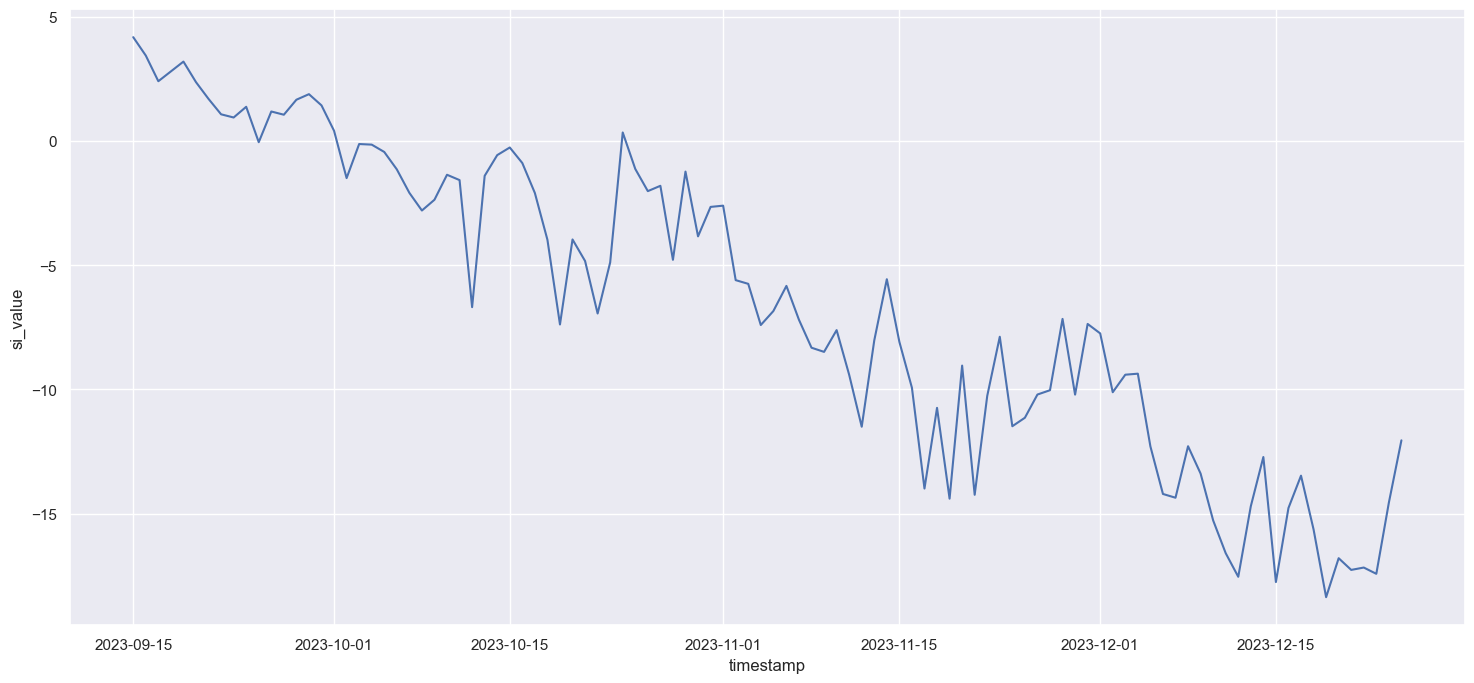

In [32]:
#
# Let's plot the temp sensors for the period we selected: all of 2022 series
# We may use:
# 'timestamp' column for timestamps of the timeseries
# 'si_value' where the sensor values are
# 'data' with the dataframe we generated in the previous box 'df_day'
# 
# Here we have a line graph with mean atmos. temp. for the TNHA site:
# 
sns.lineplot(x='timestamp', y='si_value', data=df_day)

<Axes: xlabel='timestamp', ylabel='si_value'>

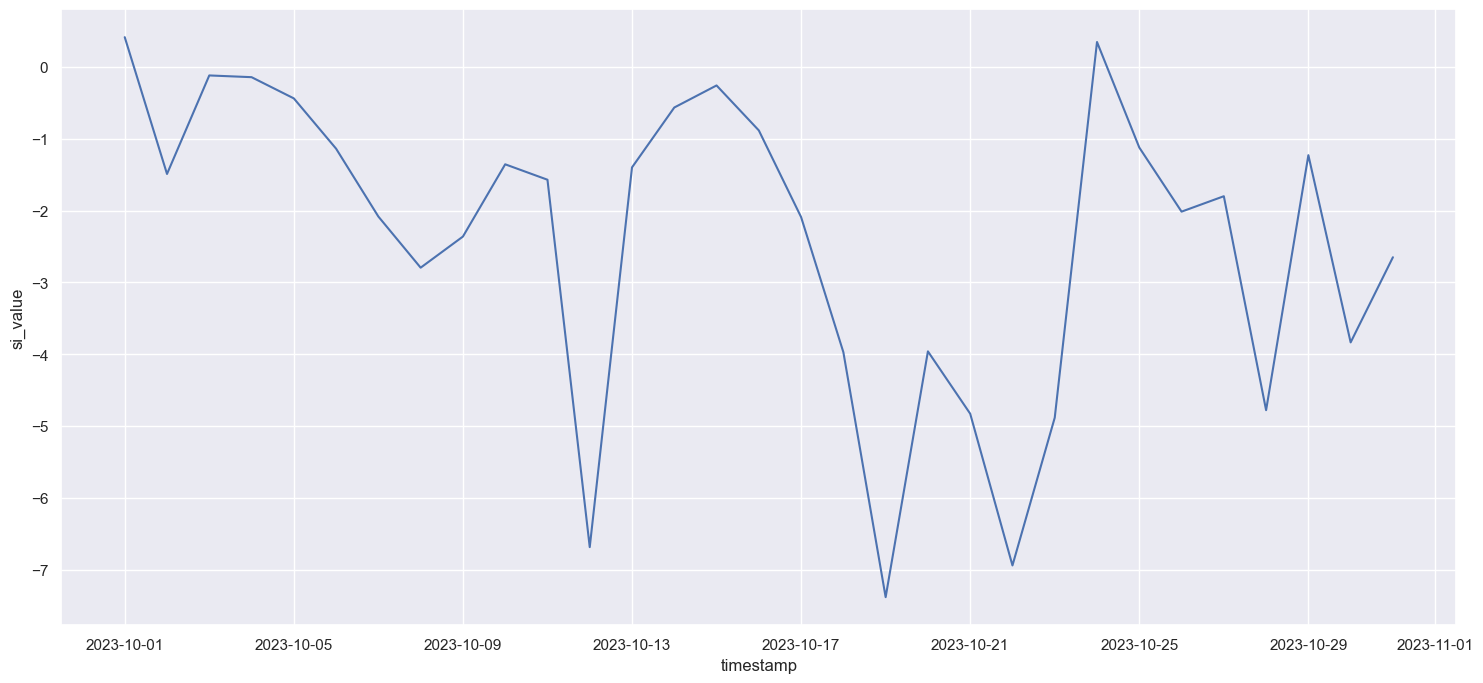

In [33]:
#
# Zoom in a particular month for more details!
# Mean temp for October, 2023
#
df_october = df_day[df_day.index.month == 10]
sns.lineplot(x='timestamp', y='si_value', data=df_october)

/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


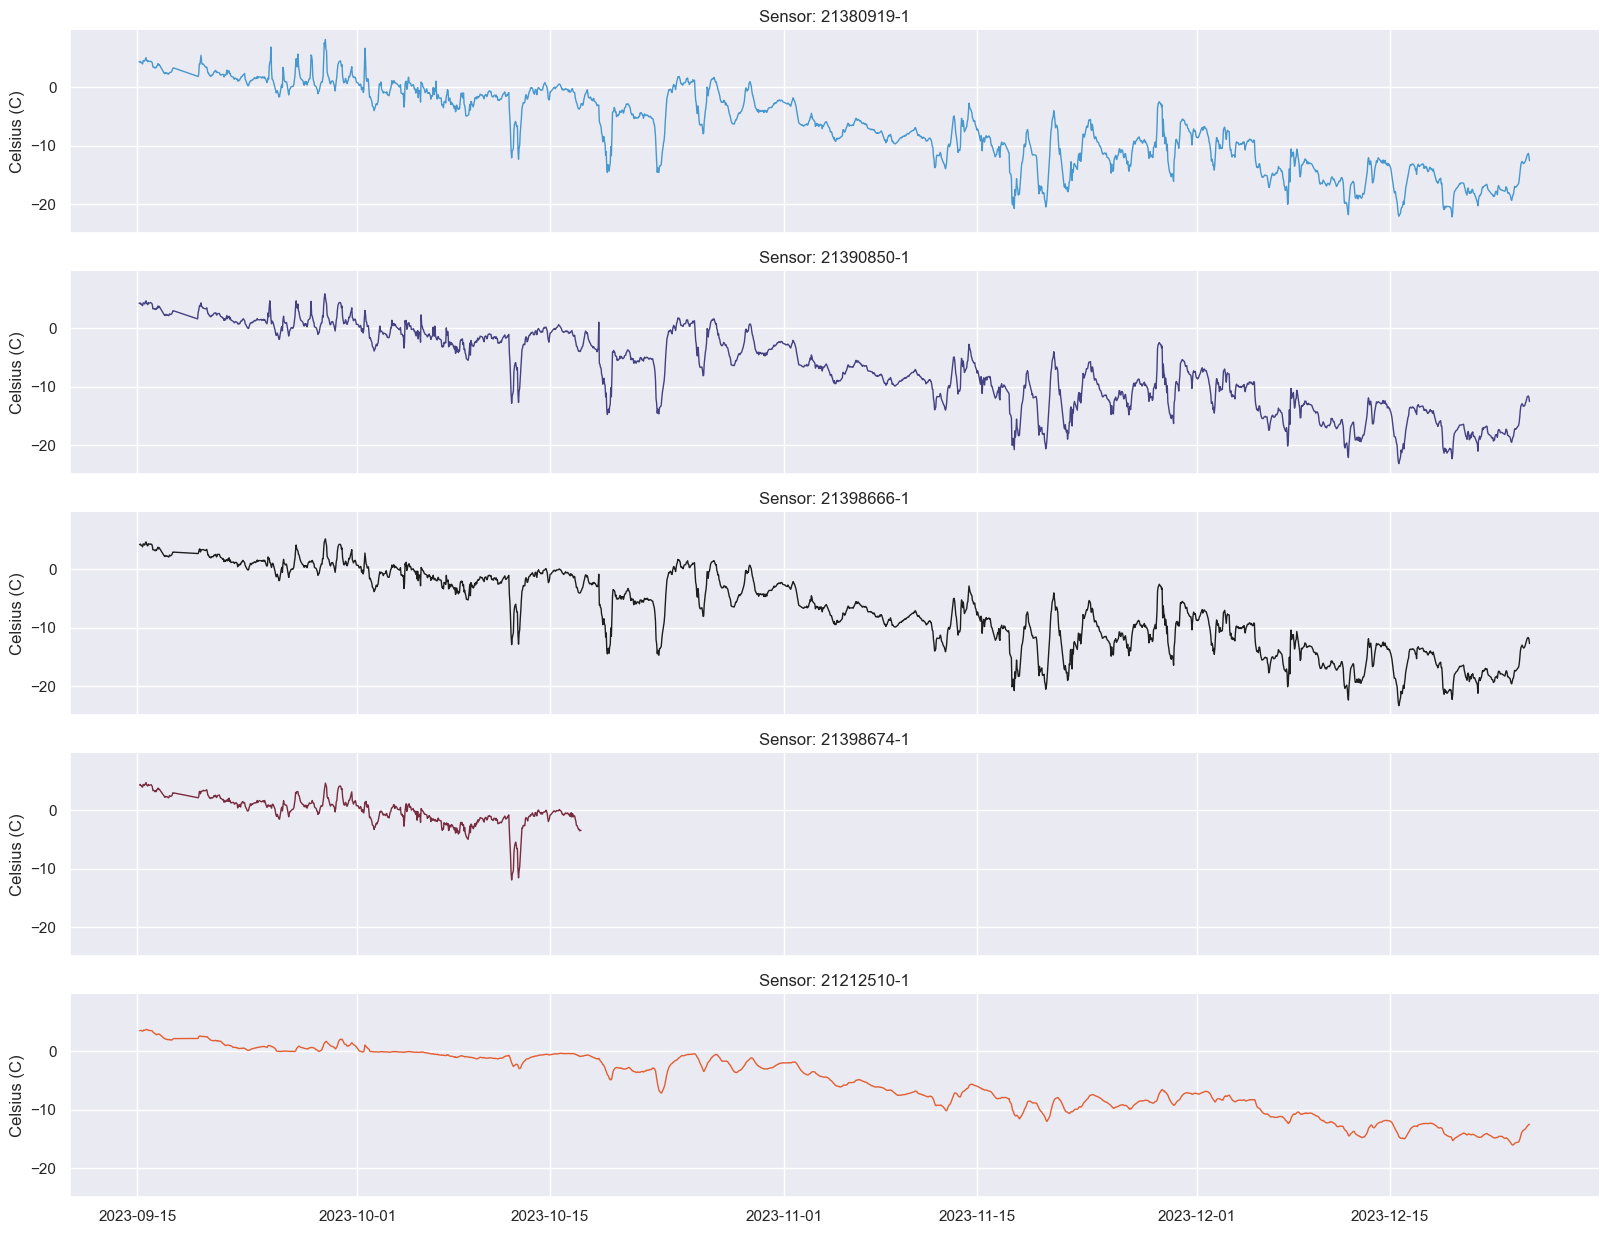

In [34]:
#
# Plot individual sensors for comparison: 
#
graph = sns.relplot(x='timestamp', 
                    y='si_value', 
                    col='sensor_sn', 
                    hue='sensor_sn', 
                    data=df_time_interval,
                    kind='line',
                    linewidth=1.0,
                    palette='icefire',
                    col_wrap=1,
                    legend=False, 
                    height=2.5,
                    aspect=6.5)
# Tweak the aspects of the plot
graph.set_titles('Sensor: {col_name}')
graph.set_axis_labels('', 'Celsius (C)')
graph.tight_layout()

# Generating heatmaps with sensor data

One thing that could be useful is for us to visualize all the sensors to look for data gaps. We do provide other tools for the same purposes (in the other example notebooks), but here is a visual way of doing plotting this data.

In [35]:
#
# Resampling to 1 day, so the graph is legible
#
df_temp = df_time_interval[df_time_interval.index.month == 9].groupby('sensor_sn').resample('1D').mean()
df_temp = df_temp.reset_index()
df_temp = df_temp.set_index('timestamp')
#
# Extra step, so we can pivot for generating the heatmap graph
df_temp = df_temp.reset_index()
df_temp['timestamp'] =  df_temp['timestamp'].dt.strftime('%m/%d')

Text(0.5, 1.0, 'TNHA-B01 - September, 2022')

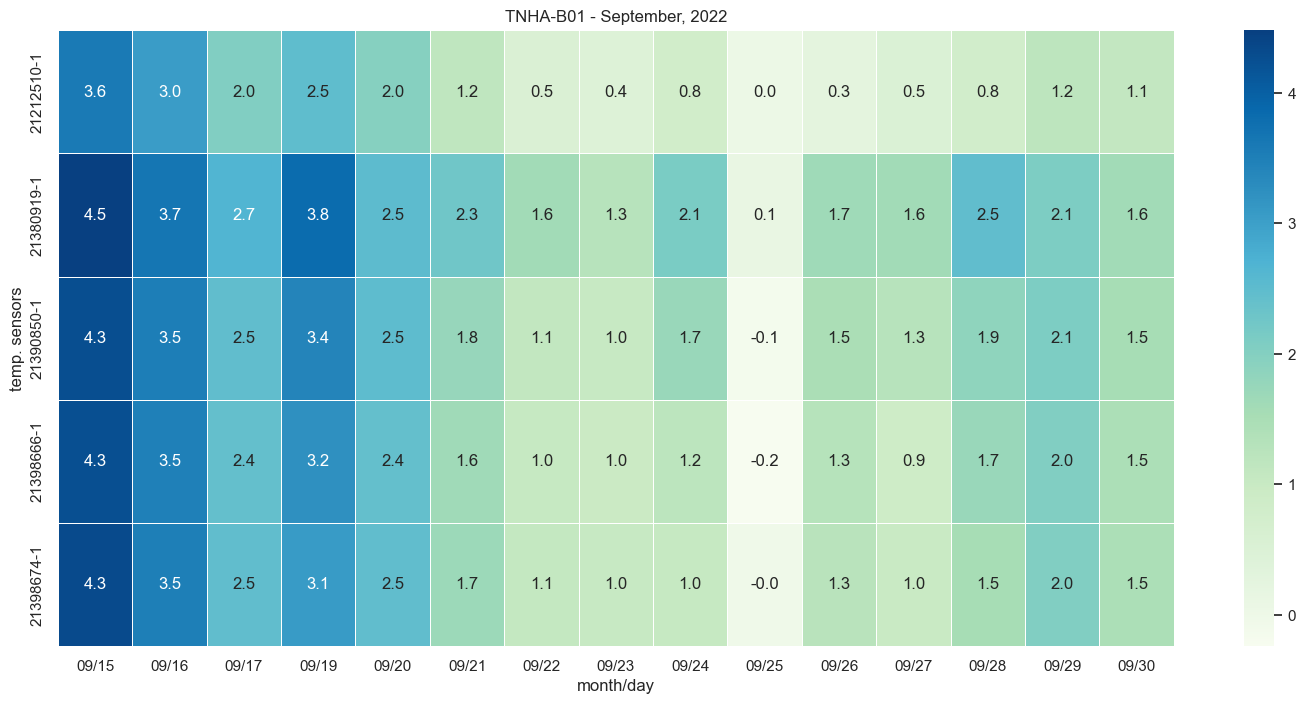

In [36]:
#
# Generate the heatmap
df_heatmap = df_temp.pivot_table(index='sensor_sn', 
                                 columns='timestamp',
                                 values='si_value')

graph = sns.heatmap(df_heatmap, annot=True, 
                                fmt='.1f', 
                                linewidth=.5,
                                cmap='GnBu')
# Adjust xy axis labels
plt.xlabel("month/day")
plt.ylabel("temp. sensors")
graph.set_title('TNHA-B01 - September, 2022')

Text(0.5, 1.0, 'TNHA-B01 - October, 2022')

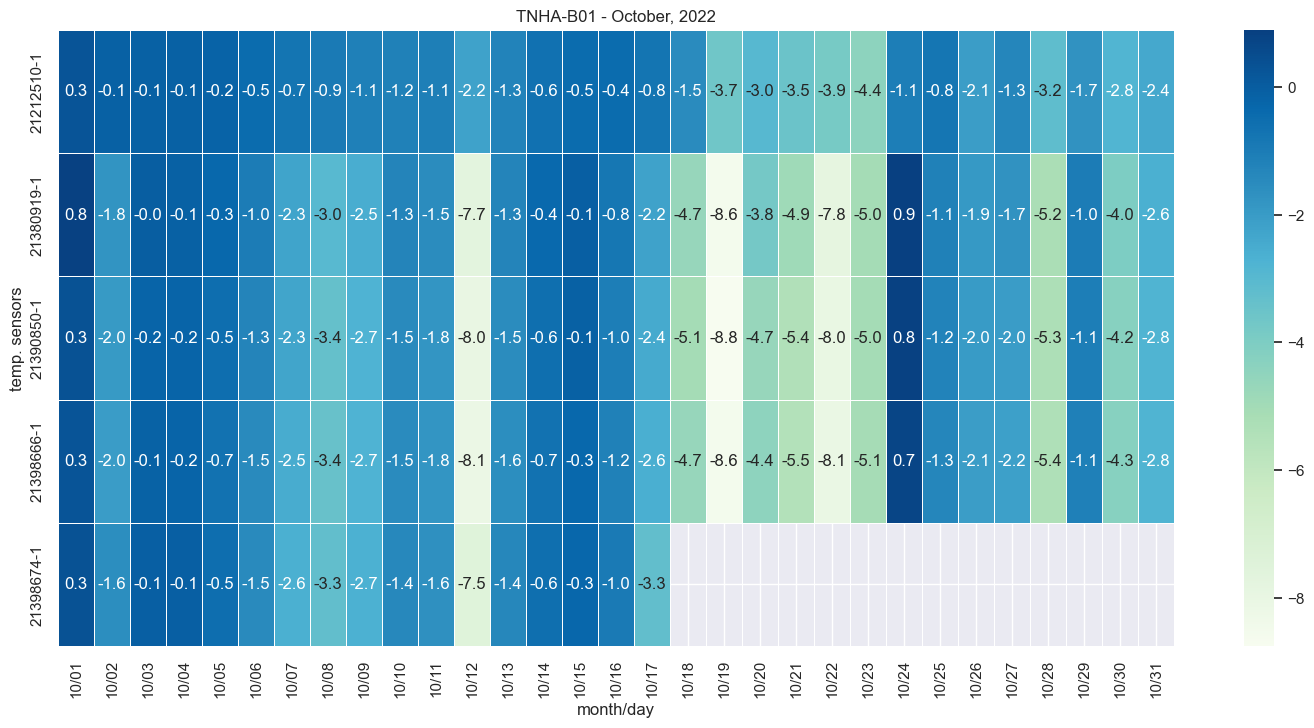

In [37]:
# 
# Neat! 
# Now let's generate the same graph for the next month, October
#
df_temp = df_time_interval[df_time_interval.index.month == 10].groupby('sensor_sn').resample('1D').mean()
df_temp = df_temp.reset_index()
df_temp = df_temp.set_index('timestamp')
df_temp = df_temp.reset_index()
df_temp['timestamp'] =  df_temp['timestamp'].dt.strftime('%m/%d')
df_heatmap = df_temp.pivot_table(index='sensor_sn', 
                                 columns='timestamp',
                                 values='si_value')

graph = sns.heatmap(df_heatmap, annot=True, 
                                fmt='.1f', 
                                linewidth=.5,
                                cmap='GnBu')
plt.xlabel("month/day")
plt.ylabel("temp. sensors")
graph.set_title('TNHA-B01 - October, 2022')

Text(0.5, 1.0, 'TNHA-B01 - November, 2022')

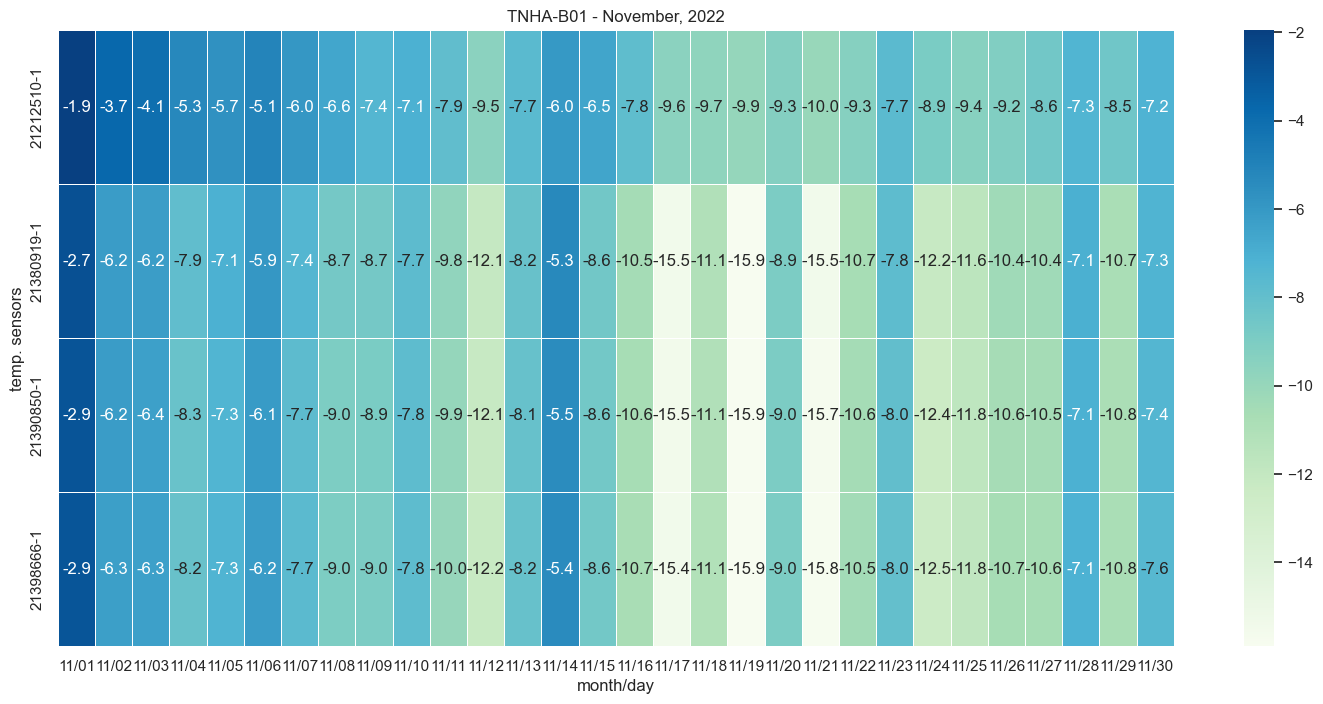

In [38]:
df_temp = df_time_interval[df_time_interval.index.month == 11].groupby('sensor_sn').resample('1D').mean()
df_temp = df_temp.reset_index()
df_temp = df_temp.set_index('timestamp')
df_temp = df_temp.reset_index()
df_temp['timestamp'] =  df_temp['timestamp'].dt.strftime('%m/%d')
df_heatmap = df_temp.pivot_table(index='sensor_sn', 
                                 columns='timestamp',
                                 values='si_value')

graph = sns.heatmap(df_heatmap, annot=True, 
                                fmt='.1f', 
                                linewidth=.5,
                                cmap='GnBu')
plt.xlabel("month/day")
plt.ylabel("temp. sensors")
graph.set_title('TNHA-B01 - November, 2022')

Text(0.5, 1.0, 'TNHA-B01 - December, 2022')

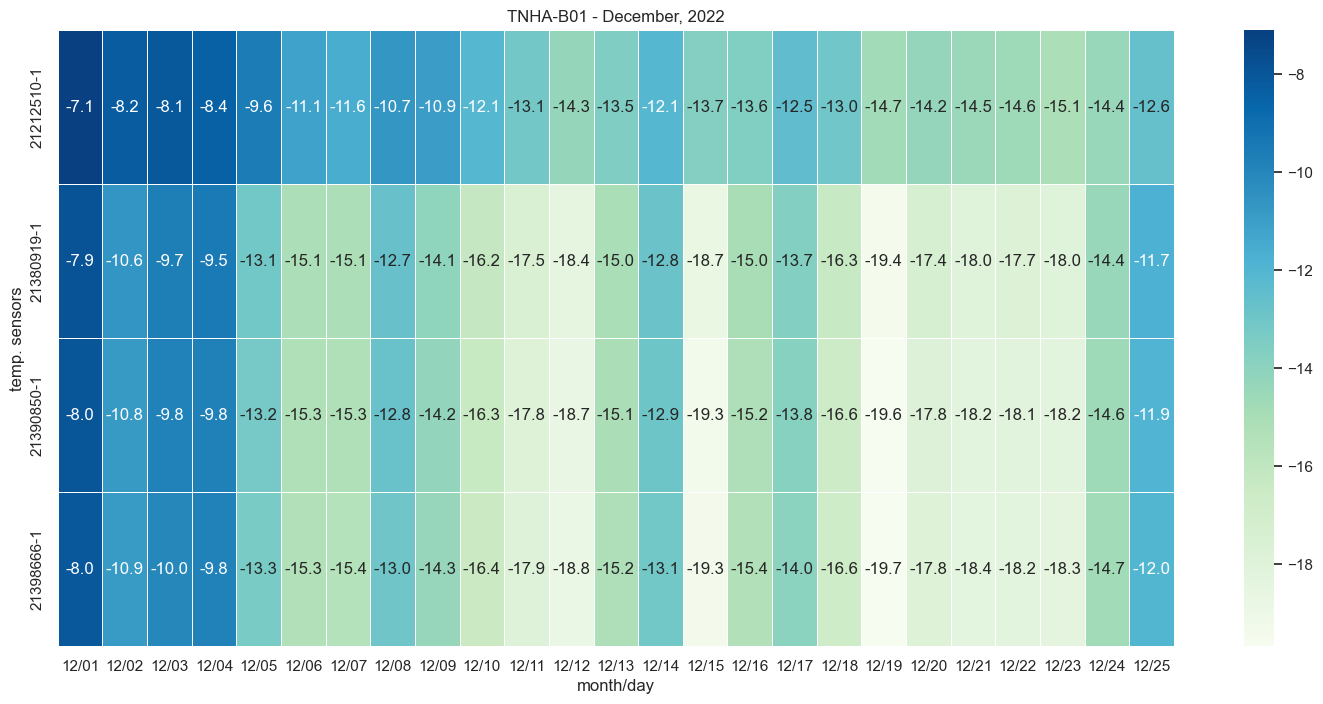

In [39]:
df_temp = df_time_interval[df_time_interval.index.month == 12].groupby('sensor_sn').resample('1D').mean()
df_temp = df_temp.reset_index()
df_temp = df_temp.set_index('timestamp')
df_temp = df_temp.reset_index()
df_temp['timestamp'] =  df_temp['timestamp'].dt.strftime('%m/%d')
df_heatmap = df_temp.pivot_table(index='sensor_sn', 
                                 columns='timestamp',
                                 values='si_value')

graph = sns.heatmap(df_heatmap, annot=True, 
                                fmt='.1f', 
                                linewidth=.5,
                                cmap='GnBu')
plt.xlabel("month/day")
plt.ylabel("temp. sensors")
graph.set_title('TNHA-B01 - December, 2022')

Prepared by: LF Murillo (CC-BY) 12-26-2023